# `MEDUSA`
aka. Dynamic-Prospective LCA aka. Union(premise, temporalis)

In [1]:
from bw_temporalis import easy_timedelta_distribution, TemporalDistribution, easy_datetime_distribution
import sys
import os
sys.path.append(os.path.realpath('../'))
from medusa.edge_extractor import *
from medusa.matrix_modifier import MatrixModifier
from medusa.medusa_lca import *
from medusa.timeline_builder import TimelineBuilder
import bw2data as bd
import bw2calc as bc
import numpy as np
import pandas as pd

In [3]:
from tests.databases import *
# db_abc_loopA_with_biosphere()

db_abc_loopA_with_biosphere_tds_CO2_only()

100%|██████████| 1/1 [00:00<00:00, 2160.90it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 16644.06it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 13981.01it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 4/4 [00:00<00:00, 10525.23it/s]

Vacuuming database 


In [4]:
demand = {('foreground', 'A'): 1}
gwp = ('GWP', 'example')

In [5]:
SKIPPABLE = [node.id for node in bd.Database('background_2008')] + [
    node.id for node in bd.Database('background_2024')
]

def filter_function(database_id: int) -> bool:
    return database_id in SKIPPABLE

In [6]:
import warnings
warnings.filterwarnings("ignore")

database_date_dict = {
            'background_2008': datetime.strptime("2008", "%Y"),
            'background_2024': datetime.strptime("2024", "%Y"),
            'foreground': "dynamic", # flag databases that should be temporally distributed with "dynamic"
        }

In [7]:
# mlca = MedusaLCA(demand, gwp, filter_function, database_date_dict, max_calc=10)
mlca = MedusaLCA(demand, gwp, filter_function, database_date_dict, max_calc=1000)

Starting graph traversal
Calculation count: 42


In [8]:
mlca.build_timeline()

All databases in database_date_dict exist as brightway project databases


,hash_producer,time_mapped_producer,date_producer,producer,producer_name,hash_consumer,time_mapped_consumer,date_consumer,consumer,consumer_name,amount,interpolation_weights
0,1995,10,1995-01-01,2,C,2000,15,2000-01-01,8,B,13.0,{'background_2008': 1}
1,1996,11,1996-01-01,2,C,2001,16,2001-01-01,8,B,13.0,{'background_2008': 1}
2,1997,12,1997-01-01,2,C,2002,17,2002-01-01,8,B,13.0,{'background_2008': 1}
3,1998,13,1998-01-01,2,C,2003,18,2003-01-01,8,B,13.0,{'background_2008': 1}
4,1999,14,1999-01-01,2,C,2004,19,2004-01-01,8,B,13.0,{'background_2008': 1}
...,...,...,...,...,...,...,...,...,...,...,...,...
79,2035,70,2035-01-01,8,B,2020,46,2020-01-01,9,A,0.4,{'background_2024': 1}
80,2036,71,2036-01-01,8,B,2021,50,2021-01-01,9,A,0.4,{'background_2024': 1}
81,2037,72,2037-01-01,8,B,2022,54,2022-01-01,9,A,0.4,{'background_2024': 1}
82,2038,73,2038-01-01,8,B,2023,58,2023-01-01,9,A,0.4,{'background_2024': 1}


In [9]:
mlca.timeline.to_excel('/Users/ajakobs/Desktop/timeline.xlsx')

In [10]:
mlca.build_datapackage()

In [11]:
mlca.lci()

In [12]:
mlca.lcia()

In [13]:
print('New MEDUSA LCA Score:', mlca.score)
print('Old static LCA Score:', mlca.static_lca.score)

New MEDUSA LCA Score: 336.90302592515826
Old static LCA Score: 337.22222278055585


In [14]:
mlca.static_lca.biosphere_matrix.toarray().dot(mlca.static_lca.supply_array)

array([337.22222278])

In [15]:
mlca.build_dynamic_biosphere()

time: 2024, act["code"]: C, id: 2, process_col_index: 0
time: 2024, act["code"]: electricity_wind, id: 3, process_col_index: 1
bio_dates:  ['2024-01-01T00:00:00']
matrix entry: value: 1 (row:0, col:1)
time: 2008, act["code"]: C, id: 4, process_col_index: 2
time: 2008, act["code"]: electricity_wind, id: 5, process_col_index: 3
bio_dates:  ['2008-01-01T00:00:00']
matrix entry: value: 1 (row:1, col:3)
time: 1995, act["code"]: C, id: 10, process_col_index: 8
time: 1996, act["code"]: C, id: 11, process_col_index: 9
time: 1997, act["code"]: C, id: 12, process_col_index: 10
time: 1998, act["code"]: C, id: 13, process_col_index: 11
time: 1999, act["code"]: C, id: 14, process_col_index: 12
time: 2000, act["code"]: B, id: 15, process_col_index: 13
bio_dates:  ['1997-12-31T12:21:36' '2003-12-31T23:16:48' '2005-12-31T10:55:12']
matrix entry: value: 1.2000000000000002 (row:2, col:13)
matrix entry: value: 4.199999999999999 (row:3, col:13)
matrix entry: value: 0.6000000000000001 (row:4, col:13)
time:

In [16]:
mlca.calculate_dynamic_lci()

0 'carbon dioxide' (None, None, None) 2024-01-01T00:00:00
{'CO2': {'time': [], 'amount': []}}
2024-01-01T00:00:00 86.885658226104
1 'carbon dioxide' (None, None, None) 2008-01-01T00:00:00
2008-01-01T00:00:00 139.6324294428037
2 'carbon dioxide' (None, None, None) 1997-12-31T12:21:36
1997-12-31T12:21:36 0.021987979867563227
3 'carbon dioxide' (None, None, None) 2003-12-31T23:16:48
2003-12-31T23:16:48 0.07695792953647128
4 'carbon dioxide' (None, None, None) 2005-12-31T10:55:12
2005-12-31T10:55:12 0.010993989933781614
5 'carbon dioxide' (None, None, None) 1999-01-01T12:21:36
1999-01-01T12:21:36 0.01826064054594756
6 'carbon dioxide' (None, None, None) 2004-12-31T23:16:48
2004-12-31T23:16:48 0.06391224191081643
7 'carbon dioxide' (None, None, None) 2007-01-01T10:55:12
2007-01-01T10:55:12 0.00913032027297378
8 'carbon dioxide' (None, None, None) 2000-01-01T12:21:36
2000-01-01T12:21:36 0.3062880046219826
9 'carbon dioxide' (None, None, None) 2005-12-31T23:16:48
2005-12-31T23:16:48 1.0720080

In [17]:
mlca.dynamic_inventory['CO2']['amount'].sum()

336.90302592515826

In [18]:
import matplotlib.pyplot as plt

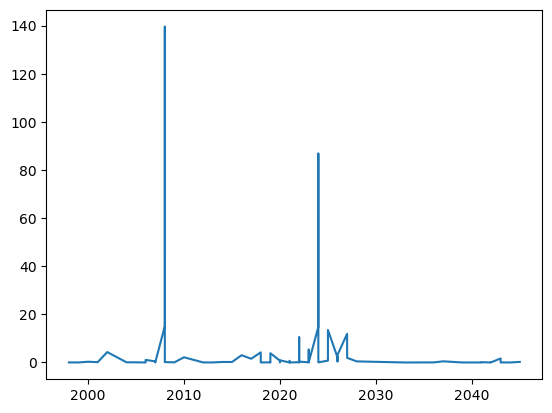

In [19]:

plt.plot(mlca.dynamic_inventory['CO2']['time'], mlca.dynamic_inventory['CO2']['amount'])

In [20]:
mlca.create_labelled_technosphere_dataframe()

,"((background_2024, C), 2024)","((background_2024, electricity_wind), 2024)","((background_2008, C), 2008)","((background_2008, electricity_wind), 2008)","((foreground, E), dynamic)","((foreground, D), dynamic)","((foreground, B), dynamic)","((foreground, A), dynamic)","((background_2024, C), 1995)","((background_2024, C), 1996)",...,"((background_2024, C), 2030)","((background_2024, C), 2031)","((background_2024, C), 2032)","((background_2024, C), 2033)","((background_2024, C), 2034)","((foreground, B), 2035)","((foreground, B), 2036)","((foreground, B), 2037)","((foreground, B), 2038)","((foreground, B), 2039)"
"((background_2024, C), 2024)",1.0,0.0,0.0,0.0,-11.0,0.0,-13.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0
"((background_2024, electricity_wind), 2024)",-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"((background_2008, C), 2008)",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"((background_2008, electricity_wind), 2008)",0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"((foreground, E), dynamic)",0.0,0.0,0.0,0.0,1.0,-2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"((foreground, B), 2035)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"((foreground, B), 2036)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"((foreground, B), 2037)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"((foreground, B), 2038)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [21]:
mlca.create_labelled_biosphere_dataframe()

,"((background_2024, C), 2024)","((background_2024, electricity_wind), 2024)","((background_2008, C), 2008)","((background_2008, electricity_wind), 2008)","((foreground, E), dynamic)","((foreground, D), dynamic)","((foreground, B), dynamic)","((foreground, A), dynamic)","((background_2024, C), 1995)","((background_2024, C), 1996)",...,"((background_2024, C), 2030)","((background_2024, C), 2031)","((background_2024, C), 2032)","((background_2024, C), 2033)","((background_2024, C), 2034)","((foreground, B), 2035)","((foreground, B), 2036)","((foreground, B), 2037)","((foreground, B), 2038)","((foreground, B), 2039)"
1,0.0,1.0,0.0,1.0,0.0,0.0,6.0,17.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,6.0,6.0,6.0,6.0


In [22]:
mlca.create_labelled_dynamic_biosphere_dataframe()

,"((background_2024, C), 2024)","((background_2024, electricity_wind), 2024)","((background_2008, C), 2008)","((background_2008, electricity_wind), 2008)","((foreground, E), dynamic)","((foreground, D), dynamic)","((foreground, B), dynamic)","((foreground, A), dynamic)","((background_2024, C), 1995)","((background_2024, C), 1996)",...,"((background_2024, C), 2030)","((background_2024, C), 2031)","((background_2024, C), 2032)","((background_2024, C), 2033)","((background_2024, C), 2034)","((foreground, B), 2035)","((foreground, B), 2036)","((foreground, B), 2037)","((foreground, B), 2038)","((foreground, B), 2039)"
"(CO2, 2024-01-01T00:00:00)",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(CO2, 2008-01-01T00:00:00)",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(CO2, 1997-12-31T12:21:36)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(CO2, 2003-12-31T23:16:48)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(CO2, 2005-12-31T10:55:12)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(CO2, 2041-12-31T23:16:48)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.2,0.0
"(CO2, 2044-01-01T10:55:12)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0
"(CO2, 2036-12-31T12:21:36)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2
"(CO2, 2042-12-31T23:16:48)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.2
